# Movie Data Analysis
by Michael Kearns

# Business Understanding

The company is creating a new movie studio and needs insight into which types of movies to make. My analysis will provide information on which types of movies have had the most success in recent years, and I will provide suggestions to the head of the movie studio on how to proceed. 

# Data Understanding

The datasets used for this analysis come from multiple online sources that collect relevant movie information, such as genre, release date, viewer reviews/ratings, gross revenue, etc. The datasets may not be directly linked or related as each source uses different formatting depending on the information it holds. Therefore, extra preparation is needed to develop significant insight.

Categorizing the data by genre is the most important strategy to determine movie success as it will directly answer the current business problem.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import numpy as np

%matplotlib inline

In [2]:
#Connect to IMDB sql database
conn = sqlite3.connect('data/im.db')


In [3]:
#List separate file names and file types for import
file_names = ['data/bom.movie_gross.csv.gz','data/rt.movie_info.tsv.gz','data/rt.reviews.tsv.gz', \
              'data/tmdb.movies.csv.gz', 'data/tn.movie_budgets.csv.gz']

file_types = [',','\t','\t',',',',']


In [4]:
#assign each file name to a dataframe and check the first few rows of each dataset
df1 = pd.read_csv(file_names[0],sep = file_types[0])
df2 = pd.read_csv(file_names[1],sep = file_types[1])
df3 = pd.read_csv(file_names[2],sep = file_types[2], encoding = 'latin-1')
df4 = pd.read_csv(file_names[3],sep = file_types[3])
df5 = pd.read_csv(file_names[4],sep = file_types[4])

dfs = [df1, df2, df3, df4, df5]

for j in range(0,5):
    print(f'Data Frame: {file_names[j]}')
    print(dfs[j].head)

Data Frame: data/bom.movie_gross.csv.gz
<bound method NDFrame.head of                                             title      studio  domestic_gross  \
0                                     Toy Story 3          BV     415000000.0   
1                      Alice in Wonderland (2010)          BV     334200000.0   
2     Harry Potter and the Deathly Hallows Part 1          WB     296000000.0   
3                                       Inception          WB     292600000.0   
4                             Shrek Forever After        P/DW     238700000.0   
...                                           ...         ...             ...   
3382                                    The Quake       Magn.          6200.0   
3383                  Edward II (2018 re-release)          FM          4800.0   
3384                                     El Pacto        Sony          2500.0   
3385                                     The Swan  Synergetic          2400.0   
3386                            An Acto

### Summary of Data

In [5]:
#Summarize column names in each dataframe
for j in range(0,5):
    print(f'Data Frame: {file_names[j]}')
    print(dfs[j].columns)

Data Frame: data/bom.movie_gross.csv.gz
Index(['title', 'studio', 'domestic_gross', 'foreign_gross', 'year'], dtype='object')
Data Frame: data/rt.movie_info.tsv.gz
Index(['id', 'synopsis', 'rating', 'genre', 'director', 'writer',
       'theater_date', 'dvd_date', 'currency', 'box_office', 'runtime',
       'studio'],
      dtype='object')
Data Frame: data/rt.reviews.tsv.gz
Index(['id', 'review', 'rating', 'fresh', 'critic', 'top_critic', 'publisher',
       'date'],
      dtype='object')
Data Frame: data/tmdb.movies.csv.gz
Index(['Unnamed: 0', 'genre_ids', 'id', 'original_language', 'original_title',
       'popularity', 'release_date', 'title', 'vote_average', 'vote_count'],
      dtype='object')
Data Frame: data/tn.movie_budgets.csv.gz
Index(['id', 'release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross'],
      dtype='object')


In [6]:
#Print info on each data frame
for j in range(0,5):
    print(f'Data Frame: df{j+1}')
    print(dfs[j].info())

Data Frame: df1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB
None
Data Frame: df2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1498 non-null   object
 2   rating        1557 non-null   object
 3   genre         1552 non-null   object
 4   director      1361 non-null   object
 5   writer        1111 non-null   object
 6   theater_date  1201 non-null   

## Data Preparatation

Data from multiple datasets will be joined together to produce any significant findings. Primarily, movies will need to be grouped based on their genre. From there, revenue and profits can be determined, as well as viewer reviews.

Many movies have multiple genre types, therefore, the genre of each movie will need to be separated so that movies can be grouped into the correct group. If a movie is categorized as "Action" and "Drama" then the data will be included in both groups.

The financial success of movies is a significant factor. With the current form, gross revenue is formatted as a string and will be converted to floats for easier analysis. 

In [7]:
#Create copy of df5
movie_gross = df5.copy()

In [8]:
#Remove rows that do not have domestic gross data
movie_gross.dropna(axis = 0, subset=['domestic_gross'],inplace = True)

In [9]:
#filter out irrelevant columns in dataframe
movie_gross = movie_gross[['movie','domestic_gross','worldwide_gross','production_budget']]
#rename 'movie' column for future merging of dataframes
movie_gross.rename(columns={'movie': 'Title'}, inplace=True)

In [10]:
#Convert financial data from strings to floats 
cols = ['domestic_gross','worldwide_gross','production_budget']
for col in cols:
    movie_gross[col]=movie_gross[col].apply(lambda x: x.replace('$','').replace(',',''))
    movie_gross[col]=movie_gross[col].astype(float)

In [11]:
#query Movie title, release year, and Genre from IMDB database
q = """ SELECT primary_title AS Title, start_year AS Year, genres AS Genres
    FROM movie_basics
    WHERE Year <= 2021
    ORDER BY Year
;"""

movie_genre = pd.read_sql(q,conn)

In [12]:
#mergemovie titles and genres together
movie_genre_gross = pd.merge(movie_gross,movie_genre, on = 'Title', how = 'inner')

#drop movie rows with no genre
movie_genre_gross.dropna(axis = 0, subset=['Genres'],inplace = True)

#separate genres if movie is identified with multiple genres
movie_genre_gross[['Genre 1', 'Genre 2', 'Genre 3']] = movie_genre_gross['Genres'].str.split(',', expand=True)

In [13]:
#Group by genre and sum gross revenue data
genre1 = movie_genre_gross.groupby('Genre 1').sum()[cols]
genre2 = movie_genre_gross.groupby('Genre 2').sum()[cols]
genre3 = movie_genre_gross.groupby('Genre 3').sum()[cols]

In [14]:
#concatenate the three dataframes to sum for total gross revenue
total_genre = pd.concat([genre1,genre2,genre3],axis = 1)
total_genre.columns= ['dg1','wg1','pb1','dg2','wg2','pb2','dg3','wg3','pb3']

#set NaN to 0
total_genre = total_genre.fillna(0)

#sum total gross
total_genre['total_worldwide_gross'] = total_genre['wg1']+total_genre['wg2']+total_genre['wg3']
total_genre = total_genre.reset_index()
total_genre.rename(columns={'index':'Genre'},inplace = True)

In [15]:
#Determine average profit for each genre

#create copy of movie_genre_gross dataframe
movie_profit = movie_genre_gross.copy()
movie_profit['Movie Profit'] = movie_profit['worldwide_gross'] - movie_profit['production_budget']

#create a new dataframe, "profit" 
profit = movie_profit[['Movie Profit','Genre 1','Genre 2','Genre 3']]

#groupby genre from each column and determine mean of "movie profit"
profit1 = profit[['Movie Profit','Genre 1']].groupby('Genre 1').mean()
profit2 = profit[['Movie Profit','Genre 2']].groupby('Genre 2').mean()
profit3 = profit[['Movie Profit','Genre 3']].groupby('Genre 3').mean()

In [16]:
#create new, "total_profit", to get average value of profit from previous groupby's
total_profit = pd.concat([profit1,profit2,profit3],axis = 1)
total_profit.columns= ['p1','p2','p3']

#create new column that takes the mean of the first 3 columns
total_profit['average_profit'] = total_profit[total_profit.columns].mean(axis=1)
total_profit = total_profit.reset_index()
total_profit.rename(columns={'index':'Genre'},inplace = True)

In [17]:
#query rating and runtime for movies from database
#Limiting the data to movies less then 3.5 hrs in run time
q = """ SELECT primary_title AS Title, averagerating, runtime_minutes AS Runtime, start_year AS Year, numvotes, genres AS Genre
    FROM movie_basics
    JOIN movie_ratings
        USING(movie_id)
    WHERE (Runtime > 60 AND Runtime <= 210 AND numvotes > 50)
;"""

movie_rating_time = pd.read_sql(q,conn)

#remove data where runtime is missing
movie_rating_time.dropna(axis = 0,subset=['Runtime'],inplace = True)

In [18]:
#create copy of dataframe d4
popularity = df4.copy()

#keep only relevant columns
popularity = popularity[['title','vote_average','vote_count']]
popularity.rename(columns={'title': 'Title'}, inplace=True)

In [19]:
#merge movie_genre, and popularity dataframes so that genre and ratings are together
movie_popularity_genre = pd.merge(movie_genre,popularity, on = 'Title', how = 'inner')

In [20]:
#remove movies with less than 1000 votes
movie_popularity_genre_votes = movie_popularity_genre[movie_popularity_genre['vote_count'] >= 1000]
movie_popularity_genre_votes = movie_popularity_genre_votes[['Genres','vote_average']]

#drop movie rows with no genre
movie_popularity_genre_votes.dropna(axis = 0, subset=['Genres'],inplace = True)

#separate genres if movie is identified with multiple genres
movie_popularity_genre_votes[['Genre 1', 'Genre 2', 'Genre 3']] = movie_genre_gross['Genres'].str.split(',', expand=True)

#add count column
movie_popularity_genre_votes['count'] = 1

In [21]:
#Groupby vote_average. This will help calculate the average rating per genre
votes1 = movie_popularity_genre_votes.groupby('Genre 1').sum()[['vote_average','count']]
votes2 = movie_popularity_genre_votes.groupby('Genre 2').sum()[['vote_average','count']]
votes3 = movie_popularity_genre_votes.groupby('Genre 3').sum()[['vote_average','count']]

In [22]:
#combine previous dataframes into "votes_avg"
votes_avg = pd.concat([votes1,votes2,votes3],axis = 1)
votes_avg.columns= ['v1','c1','v2','c2','v3','c3']
votes_avg = votes_avg.fillna(0)

#Sum ratings from each "v" column
votes_avg['total votes'] = votes_avg['v1'] + votes_avg['v2'] + votes_avg['v3']

#Sum total count from each "c" column
votes_avg['total count'] = votes_avg['c1'] + votes_avg['c2'] + votes_avg['c3']

#calculate average score for that genre type
votes_avg['vote_average'] = votes_avg['total votes']/votes_avg['total count']
votes_avg = votes_avg.reset_index()
votes_avg.rename(columns={'index':'Genre'},inplace = True)

# Exploratory Data Analysis

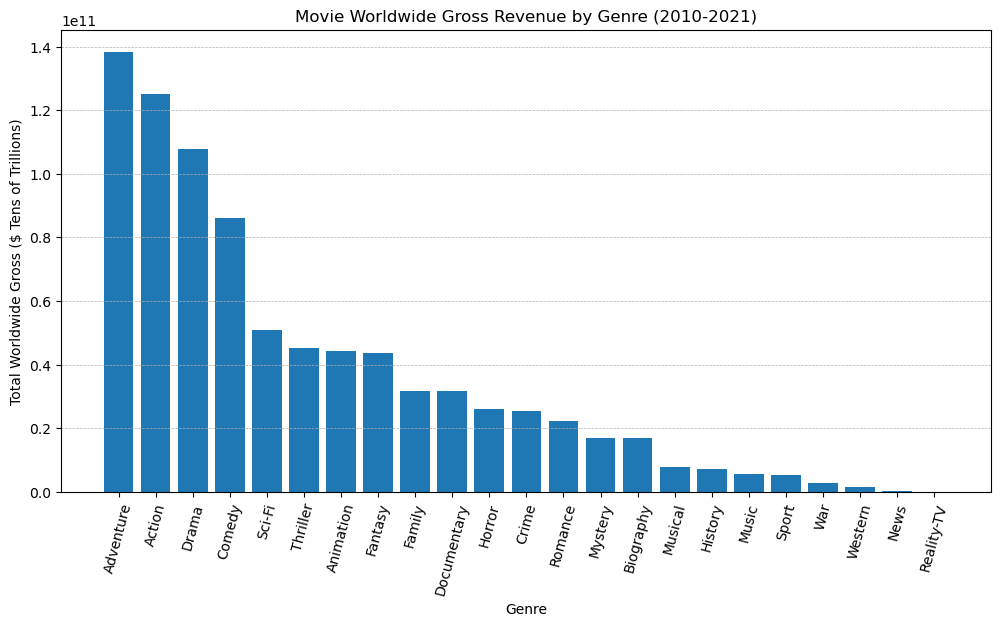

In [23]:
#Plot Bar Graph of Total Worldwide Gross Revenue by Genre
fig , ax = plt.subplots(figsize=(12,6))

wg = total_genre.copy()
wg.sort_values(by='total_worldwide_gross',ascending = False,inplace = True)

x1 = wg['Genre']
y1 = wg['total_worldwide_gross']

plot1 = ax.bar(x = x1, height = y1)
ax.set_xlabel('Genre')
ax.set_ylabel('Total Worldwide Gross ($ Tens of Trillions)')
ax.set_title ('Movie Worldwide Gross Revenue by Genre (2010-2021)')
ax.tick_params(axis='x', labelrotation=75)
ax.grid(visible = True, which = 'both', axis = "y",linestyle='--', linewidth=0.5)

plt.savefig("./images/WorldGrossRevenueByGenre.png", dpi=150,bbox_inches = 'tight')
plt.show()


Adventure, Action, and Drama movies look to be the top three movie genres with the highest gross revenues.

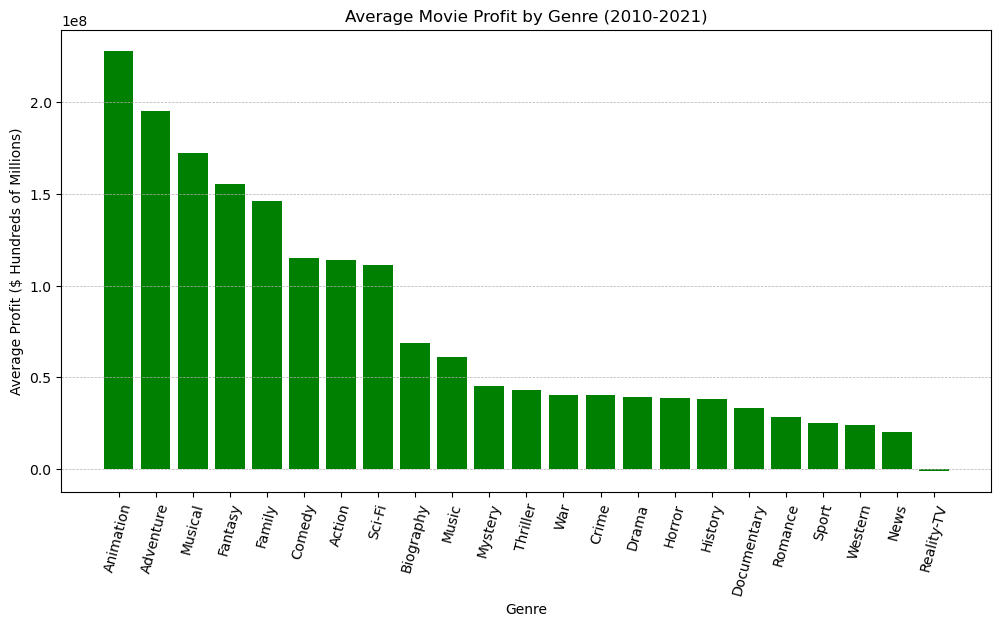

In [24]:
#Plot Bar Graph of Average Profit by Genre
fig , ax = plt.subplots(figsize=(12,6))

p = total_profit.copy()
p.sort_values(by='average_profit',ascending = False,inplace = True)

x2 = p['Genre']
y2 = p['average_profit']

plot2 = ax.bar(x = x2, height = y2,color = 'green')
ax.set_xlabel('Genre')
ax.set_ylabel('Average Profit ($ Hundreds of Millions)')
ax.set_title ('Average Movie Profit by Genre (2010-2021)')
ax.tick_params(axis='x', labelrotation=75)
ax.grid(visible = True, which = 'both', axis = "y",linestyle='--', linewidth=0.5)

plt.savefig("./images/AveProfitByGenre.png", dpi=150,bbox_inches = 'tight')
plt.show()


Animation has the highest profit. That could be due to lower production costs for animated movies compared to an Action or Adventure movie that may require special sets, equipment, and stunts.

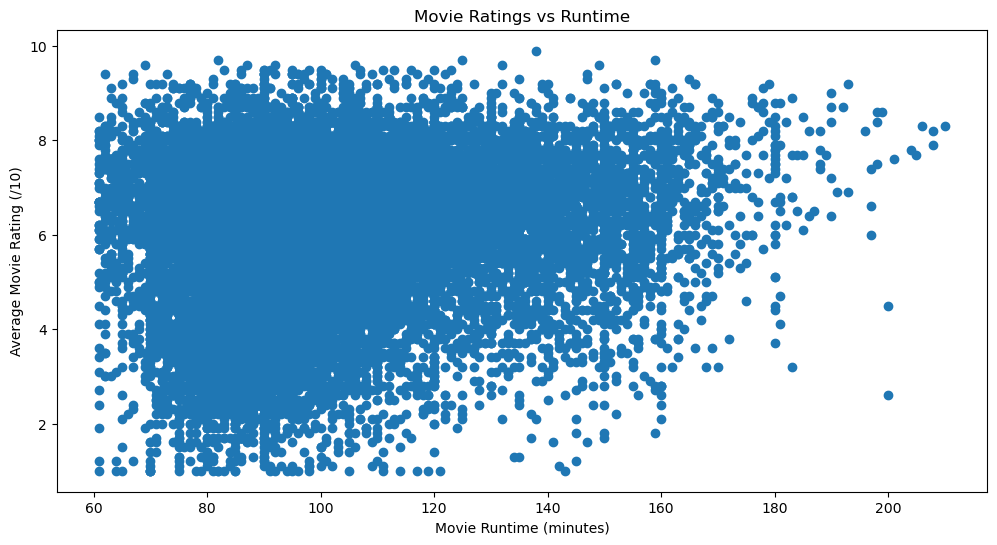

In [25]:
#Plot Scatter Plot of runtime vs average rating
fig , ax = plt.subplots(figsize=(12,6))

x = movie_rating_time['Runtime']
y = movie_rating_time['averagerating']

ax.scatter(x,y)
ax.set_xlabel('Movie Runtime (minutes)')
ax.set_ylabel('Average Movie Rating (/10)')
ax.set_title('Movie Ratings vs Runtime');

There does not look to be a clear relationship between length of movie and the movie rating.

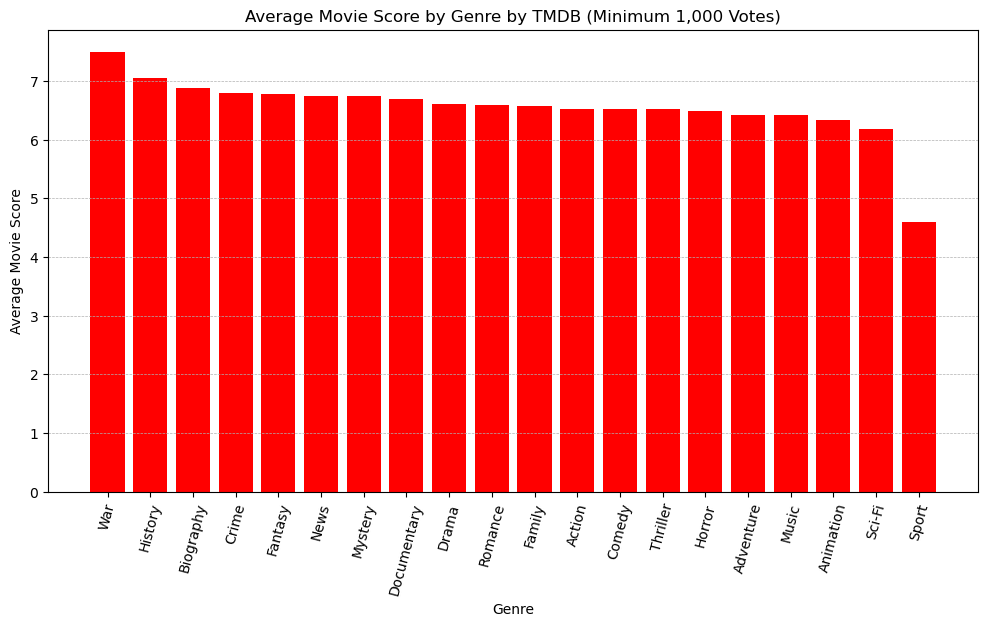

In [26]:
#Plot Bar Graph of Average Rating Score per Genre
fig , ax = plt.subplots(figsize=(12,6))

v = votes_avg.copy()
v.sort_values(by='vote_average',ascending = False,inplace = True)

x3 = v['Genre']
y3 = v['vote_average']

plot2 = ax.bar(x = x3, height = y3,color = 'red')
ax.set_xlabel('Genre')
ax.set_ylabel('Average Movie Score')
ax.set_title ('Average Movie Score by Genre by TMDB (Minimum 1,000 Votes)')
ax.tick_params(axis='x', labelrotation=75)
ax.grid(visible = True, which = 'both', axis = "y",linestyle='--', linewidth=0.5)

plt.savefig("./images/TMDBMovieScoreByGenre.png", dpi=150,bbox_inches = 'tight')
plt.show()


The average movie viewer rating is similar across genres. Going for highest rated movie based on a specific kind of movie will not be worth it.

# Conclusion and Recommendations

Based on this analysis I recommend the following three business actions:

1. The top genre of movies to make should be **Action and Adventure**. These genres bring in at least $0.25 Trillion in gross worldwide revenue compared to other genres. These types of movies will help bring in money to the studio.
2. Create a consistent lineup of **Animated** movies to ensure the company is making a profit. Animated movies will have the best profit margins due to lower production costs. This will also help appeal to a wider audience.
3. *Do not* target specific viewer ratings for movies. View ratings are similar across genres. Similarly, *do not* limit or set specific movie lengths. Runtime does not have a clear impact on viewer ratings. Therefore, focus on the production and story quality of our movies. 

# Next Steps

The next steps for the movie studio could be to focus on specific writers, directors, producers, or actors to sign on to create movies. Additional analysis could be performed to determine which individuals have had significant success in the industry and could help get the studio up and running. 